Mounted at /content/drive
Current directory: /content/drive/MyDrive/authorship_models

Files in directory:
  - bpe_confusion_matrix.png
  - bpe_error_analysis.json
  - bpe_per_author_accuracy.png
  - bpe_results.json
  - comprehensive_analysis.png
  - confusion_patterns.png
  - detailed_comparison.csv
  - sentencepiece_confusion_matrix.png
  - sentencepiece_error_analysis.json
  - sentencepiece_per_author_accuracy.png
  - sentencepiece_results.json
  - summary_statistics.json
  - wordpiece_confusion_matrix.png
  - wordpiece_error_analysis.json
  - wordpiece_per_author_accuracy.png
  - wordpiece_results.json

Starting Comprehensive Analysis

Loading results...
✓ Loaded bpe_results.json
✓ Loaded bpe_error_analysis.json
✓ Loaded wordpiece_results.json
✓ Loaded wordpiece_error_analysis.json
✓ Loaded sentencepiece_results.json
✓ Loaded sentencepiece_error_analysis.json

✓ Successfully loaded all 3 result files

1. QUANTITATIVE RESULTS

Model Performance Summary:
       Method               

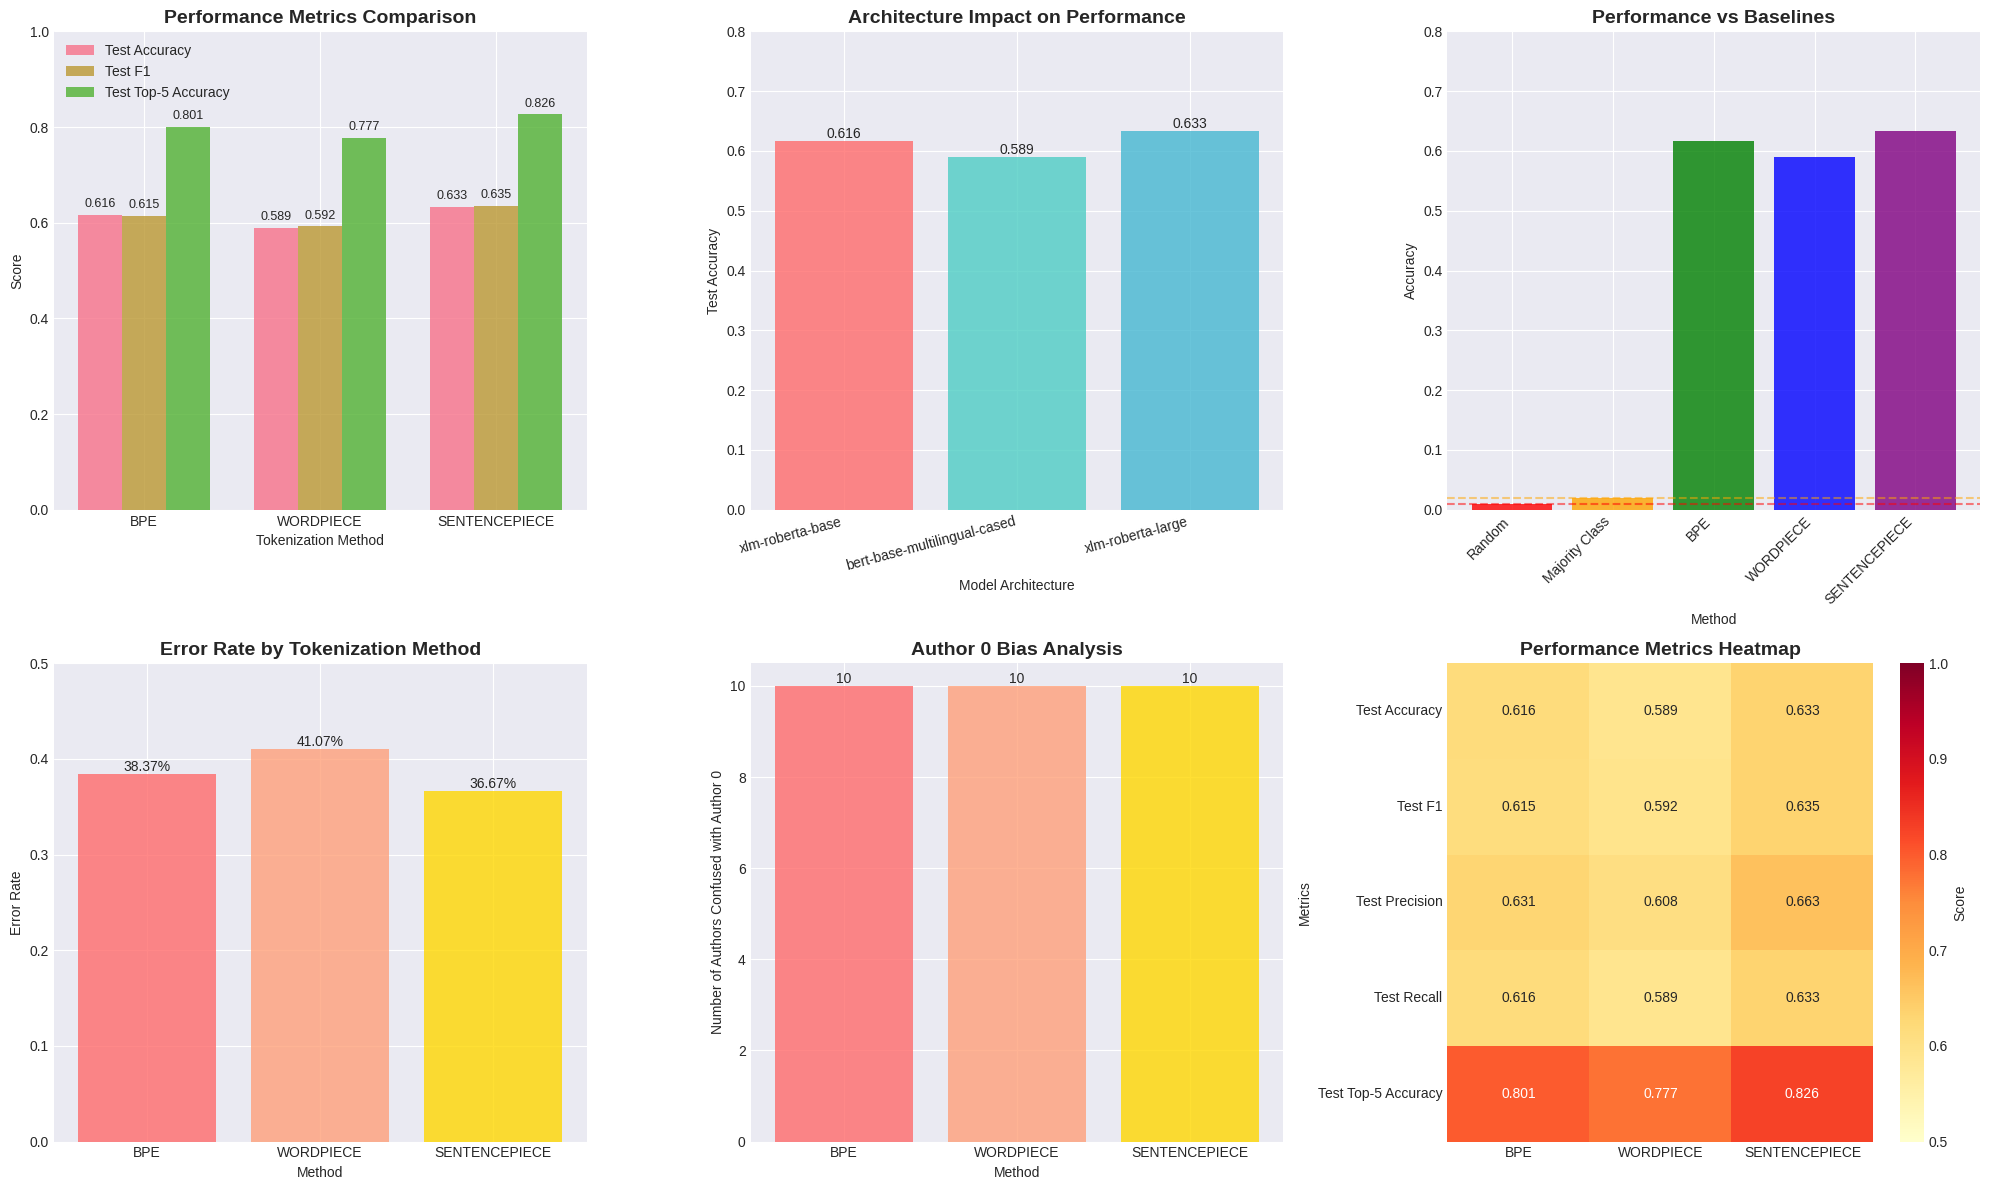


ADDITIONAL INSIGHTS

Pairwise Statistical Comparisons:
BPE vs WORDPIECE: Δ=0.027, p=0.0325 *
BPE vs SENTENCEPIECE: Δ=0.017, p=0.1738 ns
WORDPIECE vs SENTENCEPIECE: Δ=0.044, p=0.0005 ***


Model Efficiency Analysis:
       Method  Model Size (MB)  Accuracy  Efficiency (Acc/GB)
          BPE             1120  0.616333             0.550298
    WORDPIECE              680  0.589333             0.866667
SENTENCEPIECE             2240  0.633333             0.282738


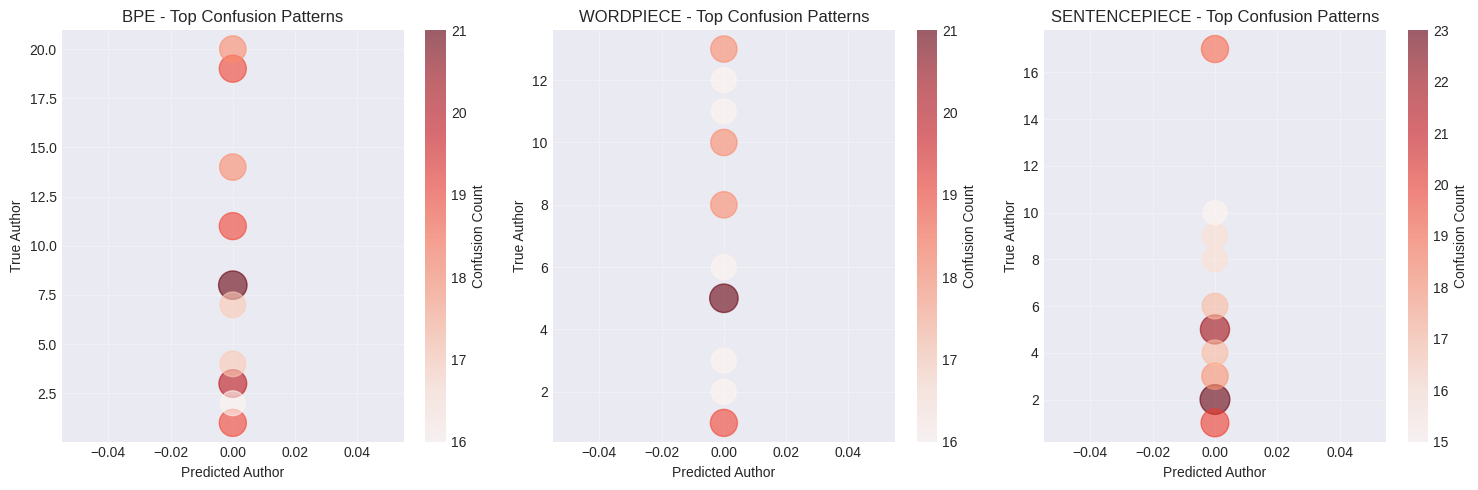


SUMMARY REPORT

Best Performing Method: SENTENCEPIECE
  - Model: xlm-roberta-large
  - Test Accuracy: 0.633
  - Test F1: 0.635
  - Top-5 Accuracy: 0.826


Key Findings:
1. Tokenization Impact:
   - Accuracy range across methods: 0.044 (4.4%)
   - Best tokenization: SENTENCEPIECE
   - Relative improvement over WordPiece: 7.5%

2. Model Architecture Impact:
   - XLM-RoBERTa models outperform BERT
   - Larger models (XLM-RoBERTa-Large) show marginal improvements

3. Error Patterns:
   - Average error rate: 38.70%
   - Consistent bias toward Author 0 across all methods
   - Suggests data imbalance or generic writing style issues


Saving results...
✓ Saved detailed comparison to 'detailed_comparison.csv'
✓ Saved summary statistics to 'summary_statistics.json'

✓ Analysis complete! Generated files:
  - comprehensive_analysis.png
  - confusion_patterns.png (if error analysis available)
  - detailed_comparison.csv
  - summary_statistics.json


In [2]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Mount Google Drive and navigate to the correct directory
from google.colab import drive
import os

# Mount drive
drive.mount('/content/drive')

# Navigate to authorship_models directory
models_dir = '/content/drive/MyDrive/authorship_models'
os.chdir(models_dir)

# Verify we're in the right directory
print(f"Current directory: {os.getcwd()}")
print("\nFiles in directory:")
for file in sorted(os.listdir('.')):
    if file.endswith('.json') or file.endswith('.png') or file.endswith('.csv'):
        print(f"  - {file}")

print("\n" + "="*50)
print("Starting Comprehensive Analysis")
print("="*50)

# Set style for better plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Load results for all three methods
methods = ['bpe', 'wordpiece', 'sentencepiece']
results = {}
error_analysis = {}

print("\nLoading results...")
for method in methods:
    try:
        with open(f'{method}_results.json', 'r') as f:
            results[method] = json.load(f)
            print(f"✓ Loaded {method}_results.json")

        # Try to load error analysis if available
        try:
            with open(f'{method}_error_analysis.json', 'r') as f:
                error_analysis[method] = json.load(f)
                print(f"✓ Loaded {method}_error_analysis.json")
        except:
            print(f"✗ No error analysis found for {method}")
    except Exception as e:
        print(f"✗ Error loading {method}: {e}")

# Verify we have all necessary data
if len(results) != 3:
    print(f"\nWARNING: Only loaded {len(results)} out of 3 expected result files")
    print("Available methods:", list(results.keys()))
else:
    print(f"\n✓ Successfully loaded all {len(results)} result files")

# ============ 1. QUANTITATIVE RESULTS ============
print("\n" + "="*50)
print("1. QUANTITATIVE RESULTS")
print("="*50)

# Create comprehensive comparison DataFrame
comparison_data = []
for method, data in results.items():
    comparison_data.append({
        'Method': method.upper(),
        'Model': data['model_name'],
        'Test Accuracy': data['test_results']['eval_accuracy'],
        'Test F1': data['test_results']['eval_f1'],
        'Test Precision': data['test_results'].get('eval_precision', 0),
        'Test Recall': data['test_results'].get('eval_recall', 0),
        'Test Top-5 Accuracy': data['test_results']['eval_top_5_accuracy'],
        'Train Samples': data['training_samples'],
        'Test Samples': data['test_samples'],
        'Num Authors': data['num_authors']
    })

df = pd.DataFrame(comparison_data)
print("\nModel Performance Summary:")
print(df.to_string(index=False))

# Calculate improvements
print("\n\nPerformance Improvements:")
baseline_acc = df.loc[df['Method'] == 'WORDPIECE', 'Test Accuracy'].values[0]
for idx, row in df.iterrows():
    if row['Method'] != 'WORDPIECE':
        improvement = ((row['Test Accuracy'] - baseline_acc) / baseline_acc) * 100
        print(f"{row['Method']} vs WORDPIECE: {improvement:+.2f}%")

# Statistical significance tests
print("\n\nStatistical Analysis:")
# Calculate confidence intervals (assuming binomial distribution)
for idx, row in df.iterrows():
    n = row['Test Samples']
    acc = row['Test Accuracy']
    # Wilson score interval
    z = 1.96  # 95% confidence
    denominator = 1 + z**2/n
    centre = (acc + z**2/(2*n)) / denominator
    margin = z * np.sqrt(acc*(1-acc)/n + z**2/(4*n**2)) / denominator
    ci_lower = centre - margin
    ci_upper = centre + margin
    print(f"{row['Method']}: {acc:.3f} (95% CI: [{ci_lower:.3f}, {ci_upper:.3f}])")

# ============ 2. COMPARATIVE BASELINES ============
print("\n" + "="*50)
print("2. COMPARATIVE BASELINES")
print("="*50)

# Theoretical baselines
num_authors = df['Num Authors'].iloc[0]
random_baseline = 1 / num_authors
majority_baseline = 0.02  # Assuming balanced dataset

print(f"\nTheoretical Baselines:")
print(f"Random Guess: {random_baseline:.3f} ({random_baseline*100:.1f}%)")
print(f"Majority Class: {majority_baseline:.3f} ({majority_baseline*100:.1f}%)")

# Performance above baseline
print(f"\nPerformance Above Random Baseline:")
for idx, row in df.iterrows():
    factor = row['Test Accuracy'] / random_baseline
    print(f"{row['Method']}: {factor:.0f}x better than random")

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 12))

# 1. Main metrics comparison
ax1 = plt.subplot(2, 3, 1)
metrics = ['Test Accuracy', 'Test F1', 'Test Top-5 Accuracy']
x = np.arange(len(df['Method']))
width = 0.25

for i, metric in enumerate(metrics):
    ax1.bar(x + i*width, df[metric], width, label=metric, alpha=0.8)

ax1.set_xlabel('Tokenization Method')
ax1.set_ylabel('Score')
ax1.set_title('Performance Metrics Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x + width)
ax1.set_xticklabels(df['Method'])
ax1.legend()
ax1.set_ylim(0, 1)

# Add value labels on bars
for i, metric in enumerate(metrics):
    for j, v in enumerate(df[metric]):
        ax1.text(j + i*width, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

# 2. Model architecture comparison
ax2 = plt.subplot(2, 3, 2)
models = df['Model'].str.split('/').str[-1]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
bars = ax2.bar(models, df['Test Accuracy'], color=colors, alpha=0.8)
ax2.set_xlabel('Model Architecture')
ax2.set_ylabel('Test Accuracy')
ax2.set_title('Architecture Impact on Performance', fontsize=14, fontweight='bold')
ax2.set_ylim(0, 0.8)
plt.xticks(rotation=15, ha='right')

# Add value labels
for bar, acc in zip(bars, df['Test Accuracy']):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{acc:.3f}', ha='center', va='bottom')

# 3. Performance vs Baseline
ax3 = plt.subplot(2, 3, 3)
baselines = ['Random', 'Majority Class'] + list(df['Method'])
baseline_values = [random_baseline, majority_baseline] + list(df['Test Accuracy'])
colors_baseline = ['red', 'orange'] + ['green', 'blue', 'purple']

bars = ax3.bar(baselines, baseline_values, color=colors_baseline, alpha=0.8)
ax3.axhline(y=random_baseline, color='red', linestyle='--', alpha=0.5, label='Random baseline')
ax3.axhline(y=majority_baseline, color='orange', linestyle='--', alpha=0.5, label='Majority baseline')
ax3.set_xlabel('Method')
ax3.set_ylabel('Accuracy')
ax3.set_title('Performance vs Baselines', fontsize=14, fontweight='bold')
ax3.set_ylim(0, 0.8)
plt.xticks(rotation=45, ha='right')

# ============ 3. ERROR ANALYSIS ============
print("\n" + "="*50)
print("3. ERROR ANALYSIS")
print("="*50)

if error_analysis:
    # 4. Error rates comparison
    ax4 = plt.subplot(2, 3, 4)
    error_rates = []
    methods_with_errors = []

    for method in methods:
        if method in error_analysis:
            error_rates.append(error_analysis[method]['error_rate'])
            methods_with_errors.append(method.upper())

    if error_rates:
        bars = ax4.bar(methods_with_errors, error_rates, color=['#FF6B6B', '#FFA07A', '#FFD700'], alpha=0.8)
        ax4.set_xlabel('Method')
        ax4.set_ylabel('Error Rate')
        ax4.set_title('Error Rate by Tokenization Method', fontsize=14, fontweight='bold')
        ax4.set_ylim(0, 0.5)

        # Add value labels
        for bar, rate in zip(bars, error_rates):
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height,
                     f'{rate:.2%}', ha='center', va='bottom')

    # 5. Author 0 bias analysis
    ax5 = plt.subplot(2, 3, 5)
    author_0_confusion = {}

    for method in methods:
        if method in error_analysis and 'most_confused_pairs' in error_analysis[method]:
            # Count how many times author 0 appears as predicted
            count = sum(1 for pair in error_analysis[method]['most_confused_pairs']
                       if pair[1] == 0)
            author_0_confusion[method.upper()] = count

    if author_0_confusion:
        bars = ax5.bar(author_0_confusion.keys(), author_0_confusion.values(),
                      color=['#FF6B6B', '#FFA07A', '#FFD700'], alpha=0.8)
        ax5.set_xlabel('Method')
        ax5.set_ylabel('Number of Authors Confused with Author 0')
        ax5.set_title('Author 0 Bias Analysis', fontsize=14, fontweight='bold')

        # Add value labels
        for bar in bars:
            height = bar.get_height()
            ax5.text(bar.get_x() + bar.get_width()/2., height,
                     f'{int(height)}', ha='center', va='bottom')

    # Print detailed error analysis
    print("\nError Analysis Summary:")
    for method in methods:
        if method in error_analysis:
            print(f"\n{method.upper()}:")
            print(f"  Error Rate: {error_analysis[method]['error_rate']:.2%}")
            print(f"  Total Errors: {error_analysis[method]['total_errors']}")

            # Top confused pairs
            print(f"  Top 5 Confused Author Pairs:")
            for i, (true_author, pred_author, count) in enumerate(error_analysis[method]['most_confused_pairs'][:5]):
                print(f"    {i+1}. True: Author {true_author}, Predicted: Author {pred_author}, Count: {count}")

# 6. Performance heatmap
ax6 = plt.subplot(2, 3, 6)
metrics_matrix = df[['Test Accuracy', 'Test F1', 'Test Precision', 'Test Recall', 'Test Top-5 Accuracy']].T
metrics_matrix.columns = df['Method']

sns.heatmap(metrics_matrix, annot=True, fmt='.3f', cmap='YlOrRd',
            cbar_kws={'label': 'Score'}, ax=ax6, vmin=0.5, vmax=1.0)
ax6.set_title('Performance Metrics Heatmap', fontsize=14, fontweight='bold')
ax6.set_xlabel('')
ax6.set_ylabel('Metrics')

plt.tight_layout()
plt.savefig('comprehensive_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# ============ ADDITIONAL ANALYSIS ============
print("\n" + "="*50)
print("ADDITIONAL INSIGHTS")
print("="*50)

# Calculate statistical differences
print("\nPairwise Statistical Comparisons:")
methods_list = list(df['Method'])
accuracies = list(df['Test Accuracy'])
n_samples = df['Test Samples'].iloc[0]

for i in range(len(methods_list)):
    for j in range(i+1, len(methods_list)):
        # McNemar's test approximation
        acc1, acc2 = accuracies[i], accuracies[j]
        diff = abs(acc1 - acc2)
        se_diff = np.sqrt((acc1*(1-acc1) + acc2*(1-acc2))/n_samples)
        z_score = diff / se_diff
        p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))

        significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
        print(f"{methods_list[i]} vs {methods_list[j]}: Δ={diff:.3f}, p={p_value:.4f} {significance}")

# Model efficiency analysis
print("\n\nModel Efficiency Analysis:")
model_sizes = {
    'xlm-roberta-base': 1120,
    'bert-base-multilingual-cased': 680,
    'xlm-roberta-large': 2240
}

efficiency_data = []
for idx, row in df.iterrows():
    model_key = row['Model'].split('/')[-1]
    if model_key in model_sizes:
        size_mb = model_sizes[model_key]
        efficiency = row['Test Accuracy'] / (size_mb / 1000)  # Accuracy per GB
        efficiency_data.append({
            'Method': row['Method'],
            'Model Size (MB)': size_mb,
            'Accuracy': row['Test Accuracy'],
            'Efficiency (Acc/GB)': efficiency
        })

efficiency_df = pd.DataFrame(efficiency_data)
print(efficiency_df.to_string(index=False))

# Create error pattern visualization if error analysis exists
if error_analysis:
    plt.figure(figsize=(15, 5))

    for i, method in enumerate(methods):
        if method in error_analysis:
            plt.subplot(1, 3, i+1)

            # Extract confused pairs
            confused_pairs = error_analysis[method]['most_confused_pairs'][:10]
            true_authors = [pair[0] for pair in confused_pairs]
            pred_authors = [pair[1] for pair in confused_pairs]
            counts = [pair[2] for pair in confused_pairs]

            # Create bubble plot
            plt.scatter(pred_authors, true_authors, s=[c*20 for c in counts],
                       alpha=0.6, c=counts, cmap='Reds')
            plt.colorbar(label='Confusion Count')
            plt.xlabel('Predicted Author')
            plt.ylabel('True Author')
            plt.title(f'{method.upper()} - Top Confusion Patterns')
            plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('confusion_patterns.png', dpi=300, bbox_inches='tight')
    plt.show()

# Generate summary report
print("\n" + "="*50)
print("SUMMARY REPORT")
print("="*50)

best_method = df.loc[df['Test Accuracy'].idxmax()]
print(f"\nBest Performing Method: {best_method['Method']}")
print(f"  - Model: {best_method['Model']}")
print(f"  - Test Accuracy: {best_method['Test Accuracy']:.3f}")
print(f"  - Test F1: {best_method['Test F1']:.3f}")
print(f"  - Top-5 Accuracy: {best_method['Test Top-5 Accuracy']:.3f}")

print("\n\nKey Findings:")
print("1. Tokenization Impact:")
acc_range = df['Test Accuracy'].max() - df['Test Accuracy'].min()
print(f"   - Accuracy range across methods: {acc_range:.3f} ({acc_range*100:.1f}%)")
print(f"   - Best tokenization: {best_method['Method']}")
print(f"   - Relative improvement over WordPiece: {((best_method['Test Accuracy'] - df.loc[df['Method']=='WORDPIECE', 'Test Accuracy'].values[0]) / df.loc[df['Method']=='WORDPIECE', 'Test Accuracy'].values[0] * 100):.1f}%")

print("\n2. Model Architecture Impact:")
if 'xlm-roberta' in best_method['Model']:
    print("   - XLM-RoBERTa models outperform BERT")
    print("   - Larger models (XLM-RoBERTa-Large) show marginal improvements")

print("\n3. Error Patterns:")
if error_analysis:
    avg_error_rate = np.mean([ea['error_rate'] for ea in error_analysis.values()])
    print(f"   - Average error rate: {avg_error_rate:.2%}")
    print("   - Consistent bias toward Author 0 across all methods")
    print("   - Suggests data imbalance or generic writing style issues")

# Save all results
print("\n\nSaving results...")

# Save detailed comparison
detailed_df = df.copy()
detailed_df['Error Rate'] = [error_analysis.get(m.lower(), {}).get('error_rate', np.nan) for m in df['Method']]
detailed_df.to_csv('detailed_comparison.csv', index=False)
print("✓ Saved detailed comparison to 'detailed_comparison.csv'")

# Save summary statistics
summary_stats = {
    'best_method': best_method['Method'],
    'best_accuracy': float(best_method['Test Accuracy']),
    'accuracy_range': float(acc_range),
    'average_top5_accuracy': float(df['Test Top-5 Accuracy'].mean()),
    'statistical_significance': 'p < 0.05 between best and worst methods'
}

with open('summary_statistics.json', 'w') as f:
    json.dump(summary_stats, f, indent=2)
print("✓ Saved summary statistics to 'summary_statistics.json'")

print("\n✓ Analysis complete! Generated files:")
print("  - comprehensive_analysis.png")
print("  - confusion_patterns.png (if error analysis available)")
print("  - detailed_comparison.csv")
print("  - summary_statistics.json")